In this notebook, we take a 2D slice of the Compass model (representative for the Earth subsurface at North Sea) and simulate the CO2 dynamics.

First, we load the Julia packages.

In [1]:
using SlimPlotting, JLD2, PyPlot;
using Seis4CCS, Polynomials;
using Seis4CCS.RockPhysics, Seis4CCS.FlowSimulation

┌ Warning: Cannot load /Users/francisyin/.julia/packages/ADCME/94vEM/deps/CustomOps/build/libadcme.dylib. Please recompile the shared library by `ADCME.precompile()` for using custom operators.
└ @ ADCME /Users/francisyin/.julia/packages/ADCME/94vEM/src/ADCME.jl:78


We download the data from dropbox and load it by JLD2

In [2]:
# run(`wget https://www.dropbox.com/s/tksm9e2w4opj9ib/Compass2km.jld2`);
JLD2.@load "Compass2km.jld2"

5-element Vector{Symbol}:
 :n
 :d
 :o
 :v
 :rho

Here, `n` denotes the dimension of the model, `d` the grid spacing, `o` the origin, `v` the acoustic velocity for each grid in km/s. We can take a look at the velocity by `plot_velocity` function in SlimPlotting package.

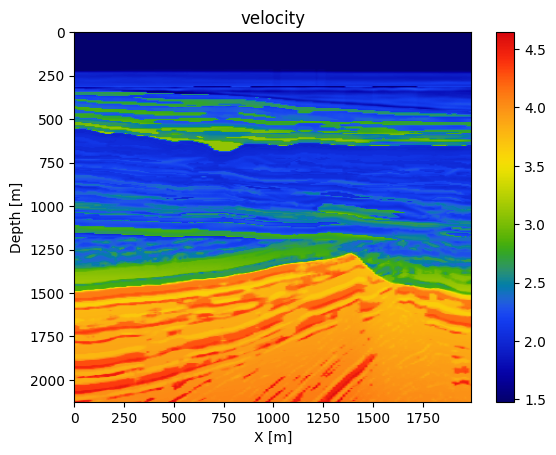

In [3]:
plot_velocity(v', d; name="velocity");colorbar();

To make a proxy permeability model representative for the North Sea area, we follow the Strategic UK CCS Storage Appraisal Project report and divide the whole model into multiple regions:

On the bottom is the main reservoir location, made of high permeable sandstones (>$200$mD)

The $50$m-depth primary seal lays over the reservoir, made of low permeable Rot Halite member ($10^3$mD)

A secondary seal is above the primary seal, made of relatively low permeable Haisborough group ($15-20$mD)

In each region, we assume a linear relationship between compressional wavespeed and permeability, indicated by the following article, where an increase of $1$km/s in velocity corresponds to an increase of $1.03$mD in permeability.

Klimentos, Theodoros. "The effects of porosity-permeability-clay content on the velocity of compressional waves." Geophysics 56.12 (1991): 1930-1939.

This velocity-to-permeability translation can be done via the function `VtoK` in Seis4CCS.jl

Then following the Kozeny-Carman relationship, we can translate the permeability to porosity via the function `Ktoϕ` in Seis4CCS.jl

In [4]:
K = VtoK(v, d);
ϕ = Ktoϕ(K, d);

We can again plot the permeability and porosity via `plot_velocity` function

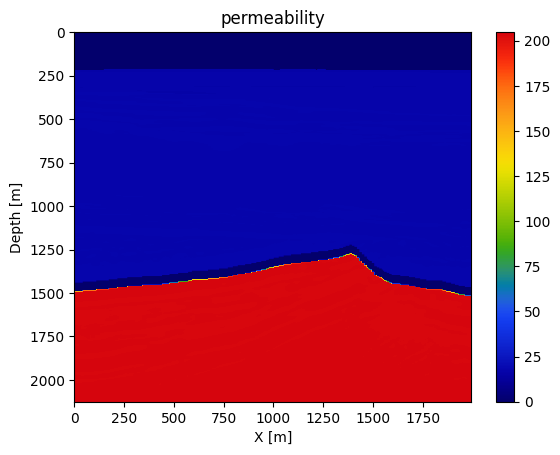

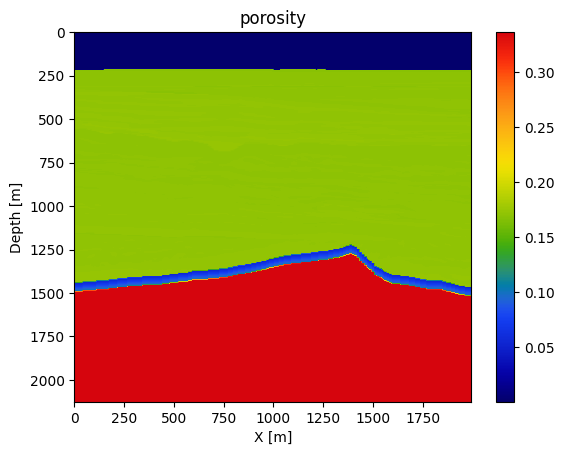

In [5]:
plot_velocity(K', d; name="permeability");colorbar();
plot_velocity(ϕ', d; name="porosity");colorbar();

We can further plot them more clearly to see the structures in each layer

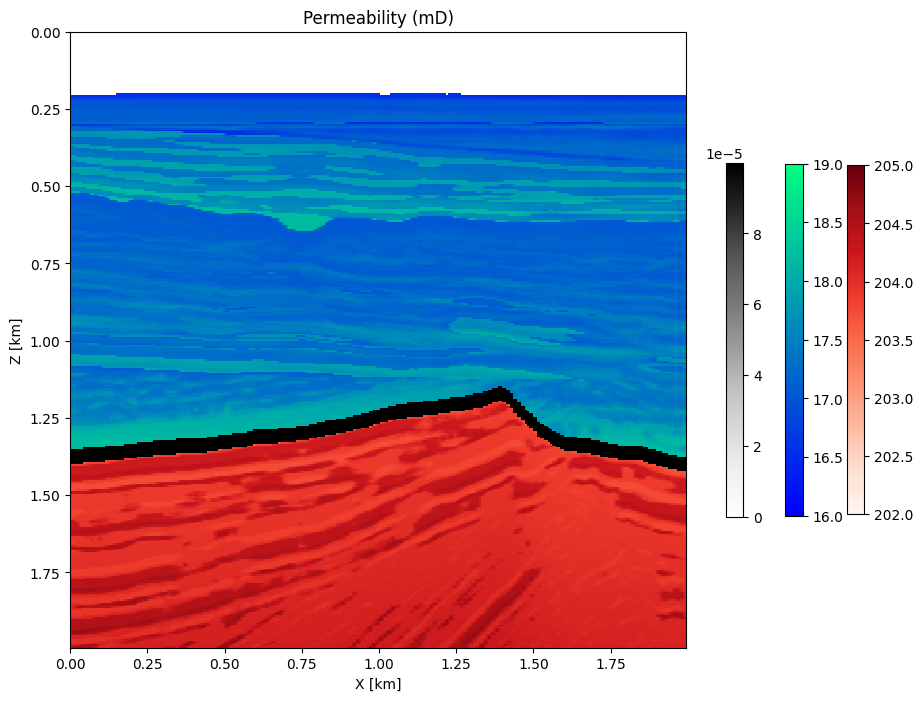

PyObject Text(0.5, 1.0, 'Permeability (mD)')

In [6]:
using PyCall
@pyimport numpy.ma as ma
p1 = pycall(ma.masked_greater, Any, K', 50)
p2 = pycall(ma.masked_less, Any, K', 50)
p3 = pycall(ma.masked_greater, Any, K', 10)

extentx = (n[1]-1)*d[1]
extentz = (n[1]-1)*d[1]

fig,ax = PyPlot.subplots(figsize=(15,8))
pic2 = ax.imshow(p2,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Reds",vmin=202,vmax=205)
cb2 = colorbar(pic2,fraction=0.015, pad=0.038);
pic1 = ax.imshow(p1,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="winter",vmin=16,vmax=19);
cb1 = colorbar(pic1,fraction=0.016, pad=0.038);
pic3 = ax.imshow(p3,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Greys",vmin=0f0,vmax=1f-4)
cb3 = colorbar(pic3,fraction=0.017, pad=0.038);
xlabel("X [km]");ylabel("Z [km]");
title("Permeability (mD)")

The permeability and porosity will serve as the input for a reservoir simulator, which generates time evolution of CO2 plume.
    
We first set up the metadata for reservoir simulation.

In [7]:
# Hyperparameter for flow simulation
hy = (n[1]-1)*d[1]        # width of the cell in y direction (now it's 2D code but CO2 lives in 3D space!)
nt = 100         # number of time steps
dt = 20         # time interval between 2 adjacent time steps (in day), you should NOT set this large otherwise the solver will be unstable

grid_ = comp_grid(n, d, hy, nt, dt);

In this software, there is assumed to be injection well(s) for CO2 injection and production well(s) for water production. Let's set up the injection/production well.

In [8]:
qw = zeros(nt, n[1], n[2]);
inj_loc = (100*d[1], 300*d[2]);    # injection location (at (100,300) cell in this case)
qw[:,Int(round(inj_loc[1]/d[1])), Int(round(inj_loc[2]/d[2]))] .= 0.3;   # in [m^3/s]

qo = zeros(nt, n[1], n[2]);
prod_loc = (300*d[1], 300*d[2]);  # injection location (at (300,300) cell in this case)
qo[:,Int(round(prod_loc[1]/d[1])),Int(round(prod_loc[2]/d[2]))] .= -0.3; # also in [m^3/s]

Where are the injection and production wells?

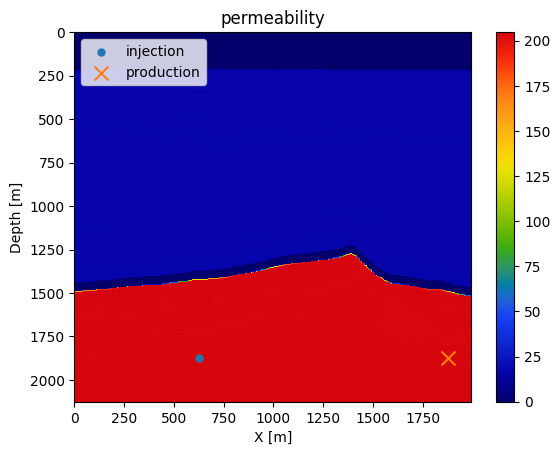

In [9]:
plot_velocity(K', d; name="permeability");colorbar();
scatter(inj_loc[1], inj_loc[2], marker=".", s=100, label="injection")
scatter(prod_loc[1], prod_loc[2], marker="x", s=100, label="production")
legend(loc=2);

Then let's do the flow simulation. This might take a while.

In [10]:
@time S, p = flow(K, ϕ, qw, qo, grid_);

Load library operator (with gradient, multiple outputs = false): /Users/francisyin/.julia/packages/FwiFlow/BrYGl/deps/CustomOps/Upwlap/build/libUpwlapOp.dylib ==> upwlap_op
Load library operator (with gradient, multiple outputs = false): /Users/francisyin/.julia/packages/FwiFlow/BrYGl/deps/CustomOps/Upwps/build/libUpwpsOp.dylib ==> upwps_op
Load library operator (with gradient, multiple outputs = false): /Users/francisyin/.julia/packages/FwiFlow/BrYGl/deps/CustomOps/Saturation/build/libSatOp.dylib ==> sat_op
593.991577 seconds (8.55 M allocations: 1.440 GiB, 0.06% gc time, 0.55% compilation time)


2022-06-08 14:03:07.519914: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-08 14:03:07.550894: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f80d861b4b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-08 14:03:07.550908: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Let's check some snapshots of the CO2 plume! What do you see?

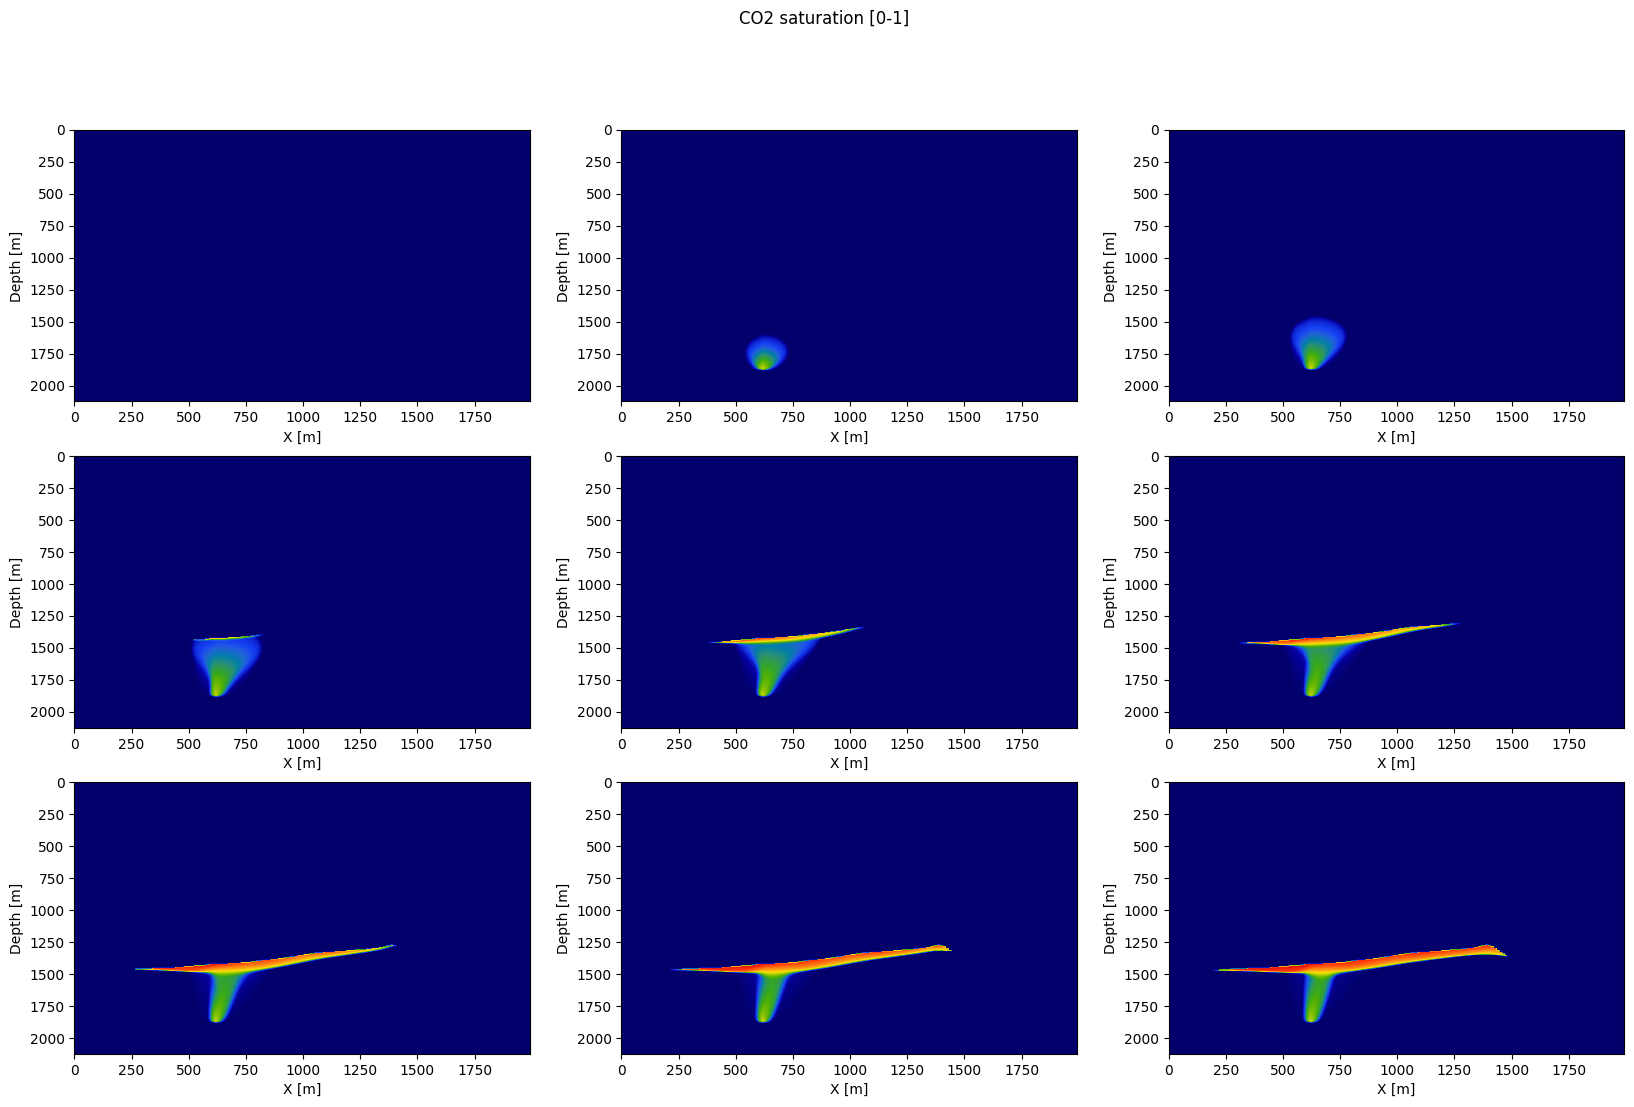

In [11]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=nt+1, length=9)));   # 9 observed time samples
for i = 1:9
    subplot(3,3,i)
    plot_velocity(S[obs[i],:,:]', d; name="", vmax=1, new_fig=false);
end
suptitle("CO2 saturation [0-1]");

How much CO2 did we inject to the system?

In [12]:
0.3 * nt * dt * 24 * 60 * 60

5.184e7

How much CO2 lives in the system now?

In [13]:
sum(S[end,:,:].*ϕ*d[1]*d[2]*hy)

5.1813883965378e7

Let's save the simulation result, saturation `S` and pressure `p`, into a JLD2 file.

In [14]:
JLD2.@save "S.jld2" S p